# Seed labeling with scANVI

In this tutorial, we go through the steps of training scANVI for seed annotation. This is useful for when we have ground truth labels for a few cells and want to annotate unlabelled cells. For more information, please refer to the original [scANVI publication](https://www.biorxiv.org/content/biorxiv/early/2019/01/29/532895.full.pdf).

Plan for this tutorial:

1. Loading the data
1. Creating the seed labels: groundtruth for a small fraction of cells
1. Training the scANVI model: transferring annotation to the whole dataset
1. Visualizing the latent space and predicted labels

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/env/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import tempfile

import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import torch

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Data Loading

For the purposes of this notebook, we will be labeling 4 cell types in a dataset of purified peripheral blood mononuclear cells from 10x Genomics:

- CD4 Regulatory T cells
- CD4 Naive T cells
- CD4 Memory T cells
- CD8 Naive T cells

In [5]:
adata = scvi.data.purified_pbmc_dataset(
    save_path=save_dir.name,
    subset_datasets=["regulatory_t", "naive_t", "memory_t", "naive_cytotoxic"],
)

INFO     Downloading file at /tmp/tmp43gcrr_r/PurifiedPBMCDataset.h5ad                                             



Downloading...:   0%|          | 0/157053.0 [00:00<?, ?it/s]


Downloading...:   4%|▍         | 6137/157053.0 [00:00<00:02, 60918.36it/s]


Downloading...:  10%|█         | 16270/157053.0 [00:00<00:01, 84587.93it/s]


Downloading...:  17%|█▋        | 26099/157053.0 [00:00<00:01, 90780.19it/s]


Downloading...:  23%|██▎       | 36014/157053.0 [00:00<00:01, 94032.92it/s]


Downloading...:  29%|██▉       | 46003/157053.0 [00:00<00:01, 96079.54it/s]


Downloading...:  36%|███▌      | 56217/157053.0 [00:00<00:01, 98130.30it/s]


Downloading...:  42%|████▏     | 66439/157053.0 [00:00<00:00, 99456.78it/s]


Downloading...:  49%|████▉     | 76771/157053.0 [00:00<00:00, 100684.62it/s]


Downloading...:  55%|█████▌    | 87089/157053.0 [00:00<00:00, 101434.98it/s]


Downloading...:  62%|██████▏   | 97492/157053.0 [00:01<00:00, 102201.81it/s]


Downloading...:  69%|██████▉   | 108062/157053.0 [00:01<00:00, 103228.62it/s]


Downloading...:  76%|███████▌  | 118646/157053.0 [00:01<00:00, 103984.59it/s]


Downloading...:  82%|████████▏ | 129321/157053.0 [00:01<00:00, 104674.05it/s]


Downloading...:  89%|████████▉ | 140133/157053.0 [00:01<00:00, 105712.90it/s]


Downloading...:  96%|█████████▌| 150997/157053.0 [00:01<00:00, 106555.84it/s]


Downloading...: 157054it [00:01, 100788.45it/s]                              

/env/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


From now on, we assume that cell type information for each cell is unavailable to us, and we seek to retrieve it.

## Automatic annotation using seed labels

In this section we hand curate and select cells which will serve as our ground truth labels.

We start by putting together a list of curated marker genes, from which we aim at identifying our ground truth cell types. These are extracted from the scANVI publication.

In [6]:
gene_subset = [
    "CD4",
    "FOXP3",
    "TNFRSF18",
    "IL2RA",
    "CTLA4",
    "CD44",
    "TCF7",
    "CD8B",
    "CCR7",
    "CD69",
    "PTPRC",
    "S100A4",
]

Then, we assign a score to every cell as a function of its cell type signature. In order to compute these scores, we need to normalize the data. Because this is not the case of scVI or scANVI, we proceed with a copy of the dataset for this step.

In [7]:
normalized = adata.copy()
sc.pp.normalize_total(normalized, target_sum=1e4)
sc.pp.log1p(normalized)

normalized = normalized[:, gene_subset].copy()
sc.pp.scale(normalized)

Now, here we have two helper functions that will help in scoring the cells, as well as taking the most confident cells with respect to these scores.

In [8]:
def get_score(normalized_adata, gene_set):
    """Returns the score per cell given a dictionary of + and - genes.

    Parameters
    ----------
    normalized_adata
      anndata dataset that has been log normalized and scaled to mean 0, std 1
    gene_set
      a dictionary with two keys: 'positive' and 'negative'
      each key should contain a list of genes
      for each gene in gene_set['positive'], its expression will be added to the score
      for each gene in gene_set['negative'], its expression will be subtracted from its score

    Returns
    -------
    array of length of n_cells containing the score per cell
    """
    score = np.zeros(normalized_adata.n_obs)
    for gene in gene_set["positive"]:
        expression = np.array(normalized_adata[:, gene].X)
        score += expression.flatten()
    for gene in gene_set["negative"]:
        expression = np.array(normalized_adata[:, gene].X)
        score -= expression.flatten()
    return score


def get_cell_mask(normalized_adata, gene_set):
    """Get cell mask.

    Calculates the score per cell for a list of genes, then returns a mask for
    the cells with the highest 50 scores.

    Parameters
    ----------
    normalized_adata
      anndata dataset that has been log normalized and scaled to mean 0, std 1
    gene_set
      a dictionary with two keys: 'positive' and 'negative'
      each key should contain a list of genes
      for each gene in gene_set['positive'], its expression will be added to the score
      for each gene in gene_set['negative'], its expression will be subtracted from its score

    Returns
    -------
    Mask for the cells with the top 50 scores over the entire dataset
    """
    score = get_score(normalized_adata, gene_set)
    cell_idx = score.argsort()[-50:]
    mask = np.zeros(normalized_adata.n_obs)
    mask[cell_idx] = 1
    return mask.astype(bool)

We run those function to identify highly confident cells, that we aim at using as seed labels

In [9]:
# hand curated list of genes for identifying ground truth


cd4_reg_geneset = {
    "positive": ["TNFRSF18", "CTLA4", "FOXP3", "IL2RA"],
    "negative": ["S100A4", "PTPRC", "CD8B"],
}

cd8_naive_geneset = {"positive": ["CD8B", "CCR7"], "negative": ["CD4"]}

cd4_naive_geneset = {
    "positive": ["CCR7", "CD4"],
    "negative": ["S100A4", "PTPRC", "FOXP3", "IL2RA", "CD69"],
}

cd4_mem_geneset = {
    "positive": ["S100A4"],
    "negative": ["IL2RA", "FOXP3", "TNFRSF18", "CCR7"],
}

In [10]:
cd4_reg_mask = get_cell_mask(
    normalized,
    cd4_reg_geneset,
)
cd8_naive_mask = get_cell_mask(
    normalized,
    cd8_naive_geneset,
)
cd4_naive_mask = get_cell_mask(
    normalized,
    cd4_naive_geneset,
)
cd4_mem_mask = get_cell_mask(
    normalized,
    cd4_mem_geneset,
)

In [11]:
seed_labels = np.array(cd4_mem_mask.shape[0] * ["Unknown"])
seed_labels[cd8_naive_mask] = "CD8 Naive T cell"
seed_labels[cd4_naive_mask] = "CD4 Naive T cell"
seed_labels[cd4_mem_mask] = "CD4 Memory T cell"
seed_labels[cd4_reg_mask] = "CD4 Regulatory T cell"

adata.obs["seed_labels"] = seed_labels

We can observe what seed label information we have now

In [12]:
adata.obs.seed_labels.value_counts()

seed_labels
Unknown    42719
CD4 Reg       50
CD4 Nai       50
CD4 Mem       50
CD8 Nai       50
Name: count, dtype: int64

As expected, we use 50 cells for each cell type!

### Transfer of annotation with scANVI

As in the harmonization notebook, we need to register the AnnData object for use in scANVI. Namely, we can ignore the batch parameter because those cells don't have much batch effect to begin with. However, we will give the seed labels for scANVI to use.

In [13]:
scvi.model.SCVI.setup_anndata(adata, batch_key=None, labels_key="seed_labels")

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



In [14]:
scvi_model = scvi.model.SCVI(adata, n_latent=30, n_layers=2)

In [15]:
scvi_model.train(100)

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.



Training:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100:   1%|          | 1/100 [00:02<04:36,  2.80s/it]


Epoch 1/100:   1%|          | 1/100 [00:02<04:36,  2.80s/it, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=2.15e+3]


Epoch 2/100:   1%|          | 1/100 [00:02<04:36,  2.80s/it, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=2.15e+3]


Epoch 2/100:   2%|▏         | 2/100 [00:05<04:01,  2.47s/it, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=2.15e+3]


Epoch 2/100:   2%|▏         | 2/100 [00:05<04:01,  2.47s/it, v_num=1, train_loss_step=1.87e+3, train_loss_epoch=1.89e+3]


Epoch 3/100:   2%|▏         | 2/100 [00:05<04:01,  2.47s/it, v_num=1, train_loss_step=1.87e+3, train_loss_epoch=1.89e+3]


Epoch 3/100:   3%|▎         | 3/100 [00:07<03:50,  2.38s/it, v_num=1, train_loss_step=1.87e+3, train_loss_epoch=1.89e+3]


Epoch 3/100:   3%|▎         | 3/100 [00:07<03:50,  2.38s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.88e+3]


Epoch 4/100:   3%|▎         | 3/100 [00:07<03:50,  2.38s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.88e+3]


Epoch 4/100:   4%|▍         | 4/100 [00:09<03:45,  2.34s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.88e+3]


Epoch 4/100:   4%|▍         | 4/100 [00:09<03:45,  2.34s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.86e+3]


Epoch 5/100:   4%|▍         | 4/100 [00:09<03:45,  2.34s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.86e+3]


Epoch 5/100:   5%|▌         | 5/100 [00:11<03:43,  2.35s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.86e+3]


Epoch 5/100:   5%|▌         | 5/100 [00:11<03:43,  2.35s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.85e+3]


Epoch 6/100:   5%|▌         | 5/100 [00:11<03:43,  2.35s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.85e+3]


Epoch 6/100:   6%|▌         | 6/100 [00:14<03:37,  2.32s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.85e+3]


Epoch 6/100:   6%|▌         | 6/100 [00:14<03:37,  2.32s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=1.84e+3]


Epoch 7/100:   6%|▌         | 6/100 [00:14<03:37,  2.32s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=1.84e+3]


Epoch 7/100:   7%|▋         | 7/100 [00:16<03:33,  2.29s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=1.84e+3]


Epoch 7/100:   7%|▋         | 7/100 [00:16<03:33,  2.29s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.83e+3]


Epoch 8/100:   7%|▋         | 7/100 [00:16<03:33,  2.29s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.83e+3]


Epoch 8/100:   8%|▊         | 8/100 [00:18<03:32,  2.31s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.83e+3]


Epoch 8/100:   8%|▊         | 8/100 [00:18<03:32,  2.31s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.83e+3]


Epoch 9/100:   8%|▊         | 8/100 [00:18<03:32,  2.31s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.83e+3]


Epoch 9/100:   9%|▉         | 9/100 [00:21<03:29,  2.30s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.83e+3]


Epoch 9/100:   9%|▉         | 9/100 [00:21<03:29,  2.30s/it, v_num=1, train_loss_step=1.86e+3, train_loss_epoch=1.82e+3]


Epoch 10/100:   9%|▉         | 9/100 [00:21<03:29,  2.30s/it, v_num=1, train_loss_step=1.86e+3, train_loss_epoch=1.82e+3]


Epoch 10/100:  10%|█         | 10/100 [00:23<03:25,  2.28s/it, v_num=1, train_loss_step=1.86e+3, train_loss_epoch=1.82e+3]


Epoch 10/100:  10%|█         | 10/100 [00:23<03:25,  2.28s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.81e+3]


Epoch 11/100:  10%|█         | 10/100 [00:23<03:25,  2.28s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.81e+3]


Epoch 11/100:  11%|█         | 11/100 [00:25<03:22,  2.27s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.81e+3]


Epoch 11/100:  11%|█         | 11/100 [00:25<03:22,  2.27s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.81e+3]


Epoch 12/100:  11%|█         | 11/100 [00:25<03:22,  2.27s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.81e+3]


Epoch 12/100:  12%|█▏        | 12/100 [00:27<03:19,  2.27s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.81e+3]


Epoch 12/100:  12%|█▏        | 12/100 [00:27<03:19,  2.27s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.8e+3] 


Epoch 13/100:  12%|█▏        | 12/100 [00:27<03:19,  2.27s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.8e+3]


Epoch 13/100:  13%|█▎        | 13/100 [00:30<03:17,  2.27s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.8e+3]


Epoch 13/100:  13%|█▎        | 13/100 [00:30<03:17,  2.27s/it, v_num=1, train_loss_step=1.83e+3, train_loss_epoch=1.8e+3]


Epoch 14/100:  13%|█▎        | 13/100 [00:30<03:17,  2.27s/it, v_num=1, train_loss_step=1.83e+3, train_loss_epoch=1.8e+3]


Epoch 14/100:  14%|█▍        | 14/100 [00:32<03:15,  2.27s/it, v_num=1, train_loss_step=1.83e+3, train_loss_epoch=1.8e+3]


Epoch 14/100:  14%|█▍        | 14/100 [00:32<03:15,  2.27s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.79e+3]


Epoch 15/100:  14%|█▍        | 14/100 [00:32<03:15,  2.27s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.79e+3]


Epoch 15/100:  15%|█▌        | 15/100 [00:34<03:12,  2.26s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.79e+3]


Epoch 15/100:  15%|█▌        | 15/100 [00:34<03:12,  2.26s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.79e+3]


Epoch 16/100:  15%|█▌        | 15/100 [00:34<03:12,  2.26s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.79e+3]


Epoch 16/100:  16%|█▌        | 16/100 [00:36<03:09,  2.26s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.79e+3]


Epoch 16/100:  16%|█▌        | 16/100 [00:36<03:09,  2.26s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=1.79e+3]


Epoch 17/100:  16%|█▌        | 16/100 [00:36<03:09,  2.26s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=1.79e+3]


Epoch 17/100:  17%|█▋        | 17/100 [00:39<03:07,  2.26s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=1.79e+3]


Epoch 17/100:  17%|█▋        | 17/100 [00:39<03:07,  2.26s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.78e+3] 


Epoch 18/100:  17%|█▋        | 17/100 [00:39<03:07,  2.26s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.78e+3]


Epoch 18/100:  18%|█▊        | 18/100 [00:41<03:05,  2.26s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.78e+3]


Epoch 18/100:  18%|█▊        | 18/100 [00:41<03:05,  2.26s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.78e+3]


Epoch 19/100:  18%|█▊        | 18/100 [00:41<03:05,  2.26s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.78e+3]


Epoch 19/100:  19%|█▉        | 19/100 [00:43<03:04,  2.28s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.78e+3]


Epoch 19/100:  19%|█▉        | 19/100 [00:43<03:04,  2.28s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.78e+3]


Epoch 20/100:  19%|█▉        | 19/100 [00:43<03:04,  2.28s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.78e+3]


Epoch 20/100:  20%|██        | 20/100 [00:46<03:04,  2.31s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.78e+3]


Epoch 20/100:  20%|██        | 20/100 [00:46<03:04,  2.31s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.78e+3]


Epoch 21/100:  20%|██        | 20/100 [00:46<03:04,  2.31s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.78e+3]


Epoch 21/100:  21%|██        | 21/100 [00:48<03:01,  2.30s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.78e+3]


Epoch 21/100:  21%|██        | 21/100 [00:48<03:01,  2.30s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.78e+3]


Epoch 22/100:  21%|██        | 21/100 [00:48<03:01,  2.30s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.78e+3]


Epoch 22/100:  22%|██▏       | 22/100 [00:50<03:00,  2.31s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.78e+3]


Epoch 22/100:  22%|██▏       | 22/100 [00:50<03:00,  2.31s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.78e+3]


Epoch 23/100:  22%|██▏       | 22/100 [00:50<03:00,  2.31s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.78e+3]


Epoch 23/100:  23%|██▎       | 23/100 [00:52<02:56,  2.29s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.78e+3]


Epoch 23/100:  23%|██▎       | 23/100 [00:52<02:56,  2.29s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.77e+3]


Epoch 24/100:  23%|██▎       | 23/100 [00:52<02:56,  2.29s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.77e+3]


Epoch 24/100:  24%|██▍       | 24/100 [00:55<02:53,  2.28s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.77e+3]


Epoch 24/100:  24%|██▍       | 24/100 [00:55<02:53,  2.28s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.77e+3]


Epoch 25/100:  24%|██▍       | 24/100 [00:55<02:53,  2.28s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.77e+3]


Epoch 25/100:  25%|██▌       | 25/100 [00:57<02:50,  2.28s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.77e+3]


Epoch 25/100:  25%|██▌       | 25/100 [00:57<02:50,  2.28s/it, v_num=1, train_loss_step=1.7e+3, train_loss_epoch=1.77e+3] 


Epoch 26/100:  25%|██▌       | 25/100 [00:57<02:50,  2.28s/it, v_num=1, train_loss_step=1.7e+3, train_loss_epoch=1.77e+3]


Epoch 26/100:  26%|██▌       | 26/100 [00:59<02:51,  2.32s/it, v_num=1, train_loss_step=1.7e+3, train_loss_epoch=1.77e+3]


Epoch 26/100:  26%|██▌       | 26/100 [00:59<02:51,  2.32s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.77e+3]


Epoch 27/100:  26%|██▌       | 26/100 [00:59<02:51,  2.32s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.77e+3]


Epoch 27/100:  27%|██▋       | 27/100 [01:02<02:49,  2.33s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.77e+3]


Epoch 27/100:  27%|██▋       | 27/100 [01:02<02:49,  2.33s/it, v_num=1, train_loss_step=1.7e+3, train_loss_epoch=1.77e+3] 


Epoch 28/100:  27%|██▋       | 27/100 [01:02<02:49,  2.33s/it, v_num=1, train_loss_step=1.7e+3, train_loss_epoch=1.77e+3]


Epoch 28/100:  28%|██▊       | 28/100 [01:04<02:47,  2.33s/it, v_num=1, train_loss_step=1.7e+3, train_loss_epoch=1.77e+3]


Epoch 28/100:  28%|██▊       | 28/100 [01:04<02:47,  2.33s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.77e+3]


Epoch 29/100:  28%|██▊       | 28/100 [01:04<02:47,  2.33s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.77e+3]


Epoch 29/100:  29%|██▉       | 29/100 [01:06<02:45,  2.34s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.77e+3]


Epoch 29/100:  29%|██▉       | 29/100 [01:06<02:45,  2.34s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.77e+3]


Epoch 30/100:  29%|██▉       | 29/100 [01:06<02:45,  2.34s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.77e+3]


Epoch 30/100:  30%|███       | 30/100 [01:09<02:42,  2.33s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.77e+3]


Epoch 30/100:  30%|███       | 30/100 [01:09<02:42,  2.33s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.77e+3]


Epoch 31/100:  30%|███       | 30/100 [01:09<02:42,  2.33s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.77e+3]


Epoch 31/100:  31%|███       | 31/100 [01:11<02:42,  2.35s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.77e+3]


Epoch 31/100:  31%|███       | 31/100 [01:11<02:42,  2.35s/it, v_num=1, train_loss_step=1.83e+3, train_loss_epoch=1.77e+3]


Epoch 32/100:  31%|███       | 31/100 [01:11<02:42,  2.35s/it, v_num=1, train_loss_step=1.83e+3, train_loss_epoch=1.77e+3]


Epoch 32/100:  32%|███▏      | 32/100 [01:13<02:37,  2.32s/it, v_num=1, train_loss_step=1.83e+3, train_loss_epoch=1.77e+3]


Epoch 32/100:  32%|███▏      | 32/100 [01:13<02:37,  2.32s/it, v_num=1, train_loss_step=1.83e+3, train_loss_epoch=1.77e+3]


Epoch 33/100:  32%|███▏      | 32/100 [01:13<02:37,  2.32s/it, v_num=1, train_loss_step=1.83e+3, train_loss_epoch=1.77e+3]


Epoch 33/100:  33%|███▎      | 33/100 [01:16<02:33,  2.29s/it, v_num=1, train_loss_step=1.83e+3, train_loss_epoch=1.77e+3]


Epoch 33/100:  33%|███▎      | 33/100 [01:16<02:33,  2.29s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.77e+3]


Epoch 34/100:  33%|███▎      | 33/100 [01:16<02:33,  2.29s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.77e+3]


Epoch 34/100:  34%|███▍      | 34/100 [01:18<02:29,  2.27s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.77e+3]


Epoch 34/100:  34%|███▍      | 34/100 [01:18<02:29,  2.27s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.77e+3]


Epoch 35/100:  34%|███▍      | 34/100 [01:18<02:29,  2.27s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.77e+3]


Epoch 35/100:  35%|███▌      | 35/100 [01:20<02:28,  2.28s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.77e+3]


Epoch 35/100:  35%|███▌      | 35/100 [01:20<02:28,  2.28s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.77e+3]


Epoch 36/100:  35%|███▌      | 35/100 [01:20<02:28,  2.28s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.77e+3]


Epoch 36/100:  36%|███▌      | 36/100 [01:22<02:27,  2.31s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.77e+3]


Epoch 36/100:  36%|███▌      | 36/100 [01:23<02:27,  2.31s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.77e+3] 


Epoch 37/100:  36%|███▌      | 36/100 [01:23<02:27,  2.31s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.77e+3]


Epoch 37/100:  37%|███▋      | 37/100 [01:25<02:25,  2.30s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.77e+3]


Epoch 37/100:  37%|███▋      | 37/100 [01:25<02:25,  2.30s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.76e+3]


Epoch 38/100:  37%|███▋      | 37/100 [01:25<02:25,  2.30s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.76e+3]


Epoch 38/100:  38%|███▊      | 38/100 [01:27<02:22,  2.30s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.76e+3]


Epoch 38/100:  38%|███▊      | 38/100 [01:27<02:22,  2.30s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 39/100:  38%|███▊      | 38/100 [01:27<02:22,  2.30s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 39/100:  39%|███▉      | 39/100 [01:29<02:19,  2.29s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 39/100:  39%|███▉      | 39/100 [01:29<02:19,  2.29s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.76e+3]


Epoch 40/100:  39%|███▉      | 39/100 [01:29<02:19,  2.29s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.76e+3]


Epoch 40/100:  40%|████      | 40/100 [01:32<02:17,  2.29s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.76e+3]


Epoch 40/100:  40%|████      | 40/100 [01:32<02:17,  2.29s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.76e+3]


Epoch 41/100:  40%|████      | 40/100 [01:32<02:17,  2.29s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.76e+3]


Epoch 41/100:  41%|████      | 41/100 [01:34<02:15,  2.29s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.76e+3]


Epoch 41/100:  41%|████      | 41/100 [01:34<02:15,  2.29s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.76e+3]


Epoch 42/100:  41%|████      | 41/100 [01:34<02:15,  2.29s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.76e+3]


Epoch 42/100:  42%|████▏     | 42/100 [01:36<02:12,  2.29s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.76e+3]


Epoch 42/100:  42%|████▏     | 42/100 [01:36<02:12,  2.29s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.76e+3]


Epoch 43/100:  42%|████▏     | 42/100 [01:36<02:12,  2.29s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.76e+3]


Epoch 43/100:  43%|████▎     | 43/100 [01:39<02:10,  2.29s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.76e+3]


Epoch 43/100:  43%|████▎     | 43/100 [01:39<02:10,  2.29s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.76e+3]


Epoch 44/100:  43%|████▎     | 43/100 [01:39<02:10,  2.29s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.76e+3]


Epoch 44/100:  44%|████▍     | 44/100 [01:41<02:08,  2.30s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.76e+3]


Epoch 44/100:  44%|████▍     | 44/100 [01:41<02:08,  2.30s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.76e+3]


Epoch 45/100:  44%|████▍     | 44/100 [01:41<02:08,  2.30s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.76e+3]


Epoch 45/100:  45%|████▌     | 45/100 [01:43<02:06,  2.30s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.76e+3]


Epoch 45/100:  45%|████▌     | 45/100 [01:43<02:06,  2.30s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.76e+3]


Epoch 46/100:  45%|████▌     | 45/100 [01:43<02:06,  2.30s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.76e+3]


Epoch 46/100:  46%|████▌     | 46/100 [01:45<02:04,  2.31s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.76e+3]


Epoch 46/100:  46%|████▌     | 46/100 [01:45<02:04,  2.31s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.76e+3]


Epoch 47/100:  46%|████▌     | 46/100 [01:45<02:04,  2.31s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.76e+3]


Epoch 47/100:  47%|████▋     | 47/100 [01:48<02:02,  2.31s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.76e+3]


Epoch 47/100:  47%|████▋     | 47/100 [01:48<02:02,  2.31s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.76e+3]


Epoch 48/100:  47%|████▋     | 47/100 [01:48<02:02,  2.31s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.76e+3]


Epoch 48/100:  48%|████▊     | 48/100 [01:50<02:00,  2.31s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.76e+3]


Epoch 48/100:  48%|████▊     | 48/100 [01:50<02:00,  2.31s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.76e+3]


Epoch 49/100:  48%|████▊     | 48/100 [01:50<02:00,  2.31s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.76e+3]


Epoch 49/100:  49%|████▉     | 49/100 [01:52<01:58,  2.32s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.76e+3]


Epoch 49/100:  49%|████▉     | 49/100 [01:52<01:58,  2.32s/it, v_num=1, train_loss_step=1.83e+3, train_loss_epoch=1.76e+3]


Epoch 50/100:  49%|████▉     | 49/100 [01:52<01:58,  2.32s/it, v_num=1, train_loss_step=1.83e+3, train_loss_epoch=1.76e+3]


Epoch 50/100:  50%|█████     | 50/100 [01:55<01:56,  2.33s/it, v_num=1, train_loss_step=1.83e+3, train_loss_epoch=1.76e+3]


Epoch 50/100:  50%|█████     | 50/100 [01:55<01:56,  2.33s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.76e+3]


Epoch 51/100:  50%|█████     | 50/100 [01:55<01:56,  2.33s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.76e+3]


Epoch 51/100:  51%|█████     | 51/100 [01:57<01:54,  2.34s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.76e+3]


Epoch 51/100:  51%|█████     | 51/100 [01:57<01:54,  2.34s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 52/100:  51%|█████     | 51/100 [01:57<01:54,  2.34s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 52/100:  52%|█████▏    | 52/100 [02:00<01:52,  2.35s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 52/100:  52%|█████▏    | 52/100 [02:00<01:52,  2.35s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.76e+3]


Epoch 53/100:  52%|█████▏    | 52/100 [02:00<01:52,  2.35s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.76e+3]


Epoch 53/100:  53%|█████▎    | 53/100 [02:02<01:50,  2.36s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.76e+3]


Epoch 53/100:  53%|█████▎    | 53/100 [02:02<01:50,  2.36s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.76e+3]


Epoch 54/100:  53%|█████▎    | 53/100 [02:02<01:50,  2.36s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.76e+3]


Epoch 54/100:  54%|█████▍    | 54/100 [02:04<01:48,  2.36s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.76e+3]


Epoch 54/100:  54%|█████▍    | 54/100 [02:04<01:48,  2.36s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 55/100:  54%|█████▍    | 54/100 [02:04<01:48,  2.36s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 55/100:  55%|█████▌    | 55/100 [02:07<01:46,  2.38s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 55/100:  55%|█████▌    | 55/100 [02:07<01:46,  2.38s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.76e+3]


Epoch 56/100:  55%|█████▌    | 55/100 [02:07<01:46,  2.38s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.76e+3]


Epoch 56/100:  56%|█████▌    | 56/100 [02:09<01:44,  2.37s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.76e+3]


Epoch 56/100:  56%|█████▌    | 56/100 [02:09<01:44,  2.37s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.76e+3]


Epoch 57/100:  56%|█████▌    | 56/100 [02:09<01:44,  2.37s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.76e+3]


Epoch 57/100:  57%|█████▋    | 57/100 [02:11<01:41,  2.37s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.76e+3]


Epoch 57/100:  57%|█████▋    | 57/100 [02:11<01:41,  2.37s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.76e+3]


Epoch 58/100:  57%|█████▋    | 57/100 [02:11<01:41,  2.37s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.76e+3]


Epoch 58/100:  58%|█████▊    | 58/100 [02:14<01:39,  2.37s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.76e+3]


Epoch 58/100:  58%|█████▊    | 58/100 [02:14<01:39,  2.37s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.76e+3]


Epoch 59/100:  58%|█████▊    | 58/100 [02:14<01:39,  2.37s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.76e+3]


Epoch 59/100:  59%|█████▉    | 59/100 [02:16<01:37,  2.37s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.76e+3]


Epoch 59/100:  59%|█████▉    | 59/100 [02:16<01:37,  2.37s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.76e+3]


Epoch 60/100:  59%|█████▉    | 59/100 [02:16<01:37,  2.37s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.76e+3]


Epoch 60/100:  60%|██████    | 60/100 [02:18<01:34,  2.35s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.76e+3]


Epoch 60/100:  60%|██████    | 60/100 [02:18<01:34,  2.35s/it, v_num=1, train_loss_step=1.7e+3, train_loss_epoch=1.76e+3] 


Epoch 61/100:  60%|██████    | 60/100 [02:18<01:34,  2.35s/it, v_num=1, train_loss_step=1.7e+3, train_loss_epoch=1.76e+3]


Epoch 61/100:  61%|██████    | 61/100 [02:21<01:31,  2.34s/it, v_num=1, train_loss_step=1.7e+3, train_loss_epoch=1.76e+3]


Epoch 61/100:  61%|██████    | 61/100 [02:21<01:31,  2.34s/it, v_num=1, train_loss_step=1.71e+3, train_loss_epoch=1.76e+3]


Epoch 62/100:  61%|██████    | 61/100 [02:21<01:31,  2.34s/it, v_num=1, train_loss_step=1.71e+3, train_loss_epoch=1.76e+3]


Epoch 62/100:  62%|██████▏   | 62/100 [02:23<01:29,  2.34s/it, v_num=1, train_loss_step=1.71e+3, train_loss_epoch=1.76e+3]


Epoch 62/100:  62%|██████▏   | 62/100 [02:23<01:29,  2.34s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 63/100:  62%|██████▏   | 62/100 [02:23<01:29,  2.34s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 63/100:  63%|██████▎   | 63/100 [02:25<01:26,  2.34s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 63/100:  63%|██████▎   | 63/100 [02:25<01:26,  2.34s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.76e+3]


Epoch 64/100:  63%|██████▎   | 63/100 [02:25<01:26,  2.34s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.76e+3]


Epoch 64/100:  64%|██████▍   | 64/100 [02:28<01:24,  2.33s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.76e+3]


Epoch 64/100:  64%|██████▍   | 64/100 [02:28<01:24,  2.33s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.76e+3]


Epoch 65/100:  64%|██████▍   | 64/100 [02:28<01:24,  2.33s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.76e+3]


Epoch 65/100:  65%|██████▌   | 65/100 [02:30<01:22,  2.35s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.76e+3]


Epoch 65/100:  65%|██████▌   | 65/100 [02:30<01:22,  2.35s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.76e+3]


Epoch 66/100:  65%|██████▌   | 65/100 [02:30<01:22,  2.35s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.76e+3]


Epoch 66/100:  66%|██████▌   | 66/100 [02:32<01:19,  2.34s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.76e+3]


Epoch 66/100:  66%|██████▌   | 66/100 [02:32<01:19,  2.34s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 67/100:  66%|██████▌   | 66/100 [02:32<01:19,  2.34s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 67/100:  67%|██████▋   | 67/100 [02:35<01:16,  2.32s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 67/100:  67%|██████▋   | 67/100 [02:35<01:16,  2.32s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.76e+3]


Epoch 68/100:  67%|██████▋   | 67/100 [02:35<01:16,  2.32s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.76e+3]


Epoch 68/100:  68%|██████▊   | 68/100 [02:37<01:15,  2.35s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.76e+3]


Epoch 68/100:  68%|██████▊   | 68/100 [02:37<01:15,  2.35s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 69/100:  68%|██████▊   | 68/100 [02:37<01:15,  2.35s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 69/100:  69%|██████▉   | 69/100 [02:39<01:12,  2.34s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 69/100:  69%|██████▉   | 69/100 [02:39<01:12,  2.34s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.76e+3]


Epoch 70/100:  69%|██████▉   | 69/100 [02:39<01:12,  2.34s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.76e+3]


Epoch 70/100:  70%|███████   | 70/100 [02:42<01:09,  2.31s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.76e+3]


Epoch 70/100:  70%|███████   | 70/100 [02:42<01:09,  2.31s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.76e+3]


Epoch 71/100:  70%|███████   | 70/100 [02:42<01:09,  2.31s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.76e+3]


Epoch 71/100:  71%|███████   | 71/100 [02:44<01:06,  2.29s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.76e+3]


Epoch 71/100:  71%|███████   | 71/100 [02:44<01:06,  2.29s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.76e+3]


Epoch 72/100:  71%|███████   | 71/100 [02:44<01:06,  2.29s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.76e+3]


Epoch 72/100:  72%|███████▏  | 72/100 [02:46<01:03,  2.28s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.76e+3]


Epoch 72/100:  72%|███████▏  | 72/100 [02:46<01:03,  2.28s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.76e+3] 


Epoch 73/100:  72%|███████▏  | 72/100 [02:46<01:03,  2.28s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.76e+3]


Epoch 73/100:  73%|███████▎  | 73/100 [02:48<01:01,  2.27s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.76e+3]


Epoch 73/100:  73%|███████▎  | 73/100 [02:48<01:01,  2.27s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.76e+3]


Epoch 74/100:  73%|███████▎  | 73/100 [02:48<01:01,  2.27s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.76e+3]


Epoch 74/100:  74%|███████▍  | 74/100 [02:51<00:58,  2.26s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.76e+3]


Epoch 74/100:  74%|███████▍  | 74/100 [02:51<00:58,  2.26s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.76e+3]


Epoch 75/100:  74%|███████▍  | 74/100 [02:51<00:58,  2.26s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.76e+3]


Epoch 75/100:  75%|███████▌  | 75/100 [02:53<00:56,  2.26s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.76e+3]


Epoch 75/100:  75%|███████▌  | 75/100 [02:53<00:56,  2.26s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.76e+3] 


Epoch 76/100:  75%|███████▌  | 75/100 [02:53<00:56,  2.26s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.76e+3]


Epoch 76/100:  76%|███████▌  | 76/100 [02:55<00:53,  2.25s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.76e+3]


Epoch 76/100:  76%|███████▌  | 76/100 [02:55<00:53,  2.25s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.76e+3]


Epoch 77/100:  76%|███████▌  | 76/100 [02:55<00:53,  2.25s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.76e+3]


Epoch 77/100:  77%|███████▋  | 77/100 [02:57<00:51,  2.24s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.76e+3]


Epoch 77/100:  77%|███████▋  | 77/100 [02:57<00:51,  2.24s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.76e+3]


Epoch 78/100:  77%|███████▋  | 77/100 [02:57<00:51,  2.24s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.76e+3]


Epoch 78/100:  78%|███████▊  | 78/100 [03:00<00:49,  2.24s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.76e+3]


Epoch 78/100:  78%|███████▊  | 78/100 [03:00<00:49,  2.24s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.76e+3]


Epoch 79/100:  78%|███████▊  | 78/100 [03:00<00:49,  2.24s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.76e+3]


Epoch 79/100:  79%|███████▉  | 79/100 [03:02<00:47,  2.25s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.76e+3]


Epoch 79/100:  79%|███████▉  | 79/100 [03:02<00:47,  2.25s/it, v_num=1, train_loss_step=1.83e+3, train_loss_epoch=1.76e+3]


Epoch 80/100:  79%|███████▉  | 79/100 [03:02<00:47,  2.25s/it, v_num=1, train_loss_step=1.83e+3, train_loss_epoch=1.76e+3]


Epoch 80/100:  80%|████████  | 80/100 [03:04<00:45,  2.25s/it, v_num=1, train_loss_step=1.83e+3, train_loss_epoch=1.76e+3]


Epoch 80/100:  80%|████████  | 80/100 [03:04<00:45,  2.25s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.76e+3]


Epoch 81/100:  80%|████████  | 80/100 [03:04<00:45,  2.25s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.76e+3]


Epoch 81/100:  81%|████████  | 81/100 [03:06<00:42,  2.25s/it, v_num=1, train_loss_step=1.68e+3, train_loss_epoch=1.76e+3]


Epoch 81/100:  81%|████████  | 81/100 [03:06<00:42,  2.25s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.76e+3]


Epoch 82/100:  81%|████████  | 81/100 [03:06<00:42,  2.25s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.76e+3]


Epoch 82/100:  82%|████████▏ | 82/100 [03:09<00:40,  2.25s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.76e+3]


Epoch 82/100:  82%|████████▏ | 82/100 [03:09<00:40,  2.25s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.76e+3]


Epoch 83/100:  82%|████████▏ | 82/100 [03:09<00:40,  2.25s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.76e+3]


Epoch 83/100:  83%|████████▎ | 83/100 [03:11<00:38,  2.26s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.76e+3]


Epoch 83/100:  83%|████████▎ | 83/100 [03:11<00:38,  2.26s/it, v_num=1, train_loss_step=1.67e+3, train_loss_epoch=1.76e+3]


Epoch 84/100:  83%|████████▎ | 83/100 [03:11<00:38,  2.26s/it, v_num=1, train_loss_step=1.67e+3, train_loss_epoch=1.76e+3]


Epoch 84/100:  84%|████████▍ | 84/100 [03:13<00:36,  2.26s/it, v_num=1, train_loss_step=1.67e+3, train_loss_epoch=1.76e+3]


Epoch 84/100:  84%|████████▍ | 84/100 [03:13<00:36,  2.26s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.76e+3]


Epoch 85/100:  84%|████████▍ | 84/100 [03:13<00:36,  2.26s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.76e+3]


Epoch 85/100:  85%|████████▌ | 85/100 [03:15<00:33,  2.25s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.76e+3]


Epoch 85/100:  85%|████████▌ | 85/100 [03:15<00:33,  2.25s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.76e+3]


Epoch 86/100:  85%|████████▌ | 85/100 [03:15<00:33,  2.25s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.76e+3]


Epoch 86/100:  86%|████████▌ | 86/100 [03:18<00:31,  2.25s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.76e+3]


Epoch 86/100:  86%|████████▌ | 86/100 [03:18<00:31,  2.25s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.76e+3]


Epoch 87/100:  86%|████████▌ | 86/100 [03:18<00:31,  2.25s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.76e+3]


Epoch 87/100:  87%|████████▋ | 87/100 [03:20<00:29,  2.25s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.76e+3]


Epoch 87/100:  87%|████████▋ | 87/100 [03:20<00:29,  2.25s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.76e+3]


Epoch 88/100:  87%|████████▋ | 87/100 [03:20<00:29,  2.25s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.76e+3]


Epoch 88/100:  88%|████████▊ | 88/100 [03:22<00:27,  2.25s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.76e+3]


Epoch 88/100:  88%|████████▊ | 88/100 [03:22<00:27,  2.25s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 89/100:  88%|████████▊ | 88/100 [03:22<00:27,  2.25s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 89/100:  89%|████████▉ | 89/100 [03:24<00:24,  2.25s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 89/100:  89%|████████▉ | 89/100 [03:24<00:24,  2.25s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.76e+3] 


Epoch 90/100:  89%|████████▉ | 89/100 [03:24<00:24,  2.25s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.76e+3]


Epoch 90/100:  90%|█████████ | 90/100 [03:27<00:22,  2.25s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.76e+3]


Epoch 90/100:  90%|█████████ | 90/100 [03:27<00:22,  2.25s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.76e+3]


Epoch 91/100:  90%|█████████ | 90/100 [03:27<00:22,  2.25s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.76e+3]


Epoch 91/100:  91%|█████████ | 91/100 [03:29<00:20,  2.25s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.76e+3]


Epoch 91/100:  91%|█████████ | 91/100 [03:29<00:20,  2.25s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.76e+3]


Epoch 92/100:  91%|█████████ | 91/100 [03:29<00:20,  2.25s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.76e+3]


Epoch 92/100:  92%|█████████▏| 92/100 [03:31<00:18,  2.26s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.76e+3]


Epoch 92/100:  92%|█████████▏| 92/100 [03:31<00:18,  2.26s/it, v_num=1, train_loss_step=1.71e+3, train_loss_epoch=1.76e+3]


Epoch 93/100:  92%|█████████▏| 92/100 [03:31<00:18,  2.26s/it, v_num=1, train_loss_step=1.71e+3, train_loss_epoch=1.76e+3]


Epoch 93/100:  93%|█████████▎| 93/100 [03:34<00:16,  2.29s/it, v_num=1, train_loss_step=1.71e+3, train_loss_epoch=1.76e+3]


Epoch 93/100:  93%|█████████▎| 93/100 [03:34<00:16,  2.29s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.76e+3]


Epoch 94/100:  93%|█████████▎| 93/100 [03:34<00:16,  2.29s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.76e+3]


Epoch 94/100:  94%|█████████▍| 94/100 [03:36<00:13,  2.32s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.76e+3]


Epoch 94/100:  94%|█████████▍| 94/100 [03:36<00:13,  2.32s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.76e+3]


Epoch 95/100:  94%|█████████▍| 94/100 [03:36<00:13,  2.32s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.76e+3]


Epoch 95/100:  95%|█████████▌| 95/100 [03:38<00:11,  2.32s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.76e+3]


Epoch 95/100:  95%|█████████▌| 95/100 [03:38<00:11,  2.32s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.76e+3]


Epoch 96/100:  95%|█████████▌| 95/100 [03:38<00:11,  2.32s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.76e+3]


Epoch 96/100:  96%|█████████▌| 96/100 [03:41<00:09,  2.31s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.76e+3]


Epoch 96/100:  96%|█████████▌| 96/100 [03:41<00:09,  2.31s/it, v_num=1, train_loss_step=1.71e+3, train_loss_epoch=1.76e+3]


Epoch 97/100:  96%|█████████▌| 96/100 [03:41<00:09,  2.31s/it, v_num=1, train_loss_step=1.71e+3, train_loss_epoch=1.76e+3]


Epoch 97/100:  97%|█████████▋| 97/100 [03:43<00:06,  2.29s/it, v_num=1, train_loss_step=1.71e+3, train_loss_epoch=1.76e+3]


Epoch 97/100:  97%|█████████▋| 97/100 [03:43<00:06,  2.29s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.76e+3]


Epoch 98/100:  97%|█████████▋| 97/100 [03:43<00:06,  2.29s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.76e+3]


Epoch 98/100:  98%|█████████▊| 98/100 [03:45<00:04,  2.31s/it, v_num=1, train_loss_step=1.74e+3, train_loss_epoch=1.76e+3]


Epoch 98/100:  98%|█████████▊| 98/100 [03:45<00:04,  2.31s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.76e+3]


Epoch 99/100:  98%|█████████▊| 98/100 [03:45<00:04,  2.31s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.76e+3]


Epoch 99/100:  99%|█████████▉| 99/100 [03:47<00:02,  2.30s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=1.76e+3]


Epoch 99/100:  99%|█████████▉| 99/100 [03:47<00:02,  2.30s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 100/100:  99%|█████████▉| 99/100 [03:47<00:02,  2.30s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 100/100: 100%|██████████| 100/100 [03:50<00:00,  2.28s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.76e+3]


Epoch 100/100: 100%|██████████| 100/100 [03:50<00:00,  2.28s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.76e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.



Epoch 100/100: 100%|██████████| 100/100 [03:50<00:00,  2.30s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.76e+3]

Now we can train scANVI and transfer the labels!

In [16]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, "Unknown")

In [17]:
scanvi_model.train(25)

INFO     Training for 25 epochs.                                                                                   


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.



Training:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 1/25:   0%|          | 0/25 [00:00<?, ?it/s]


Epoch 1/25:   4%|▍         | 1/25 [00:04<01:59,  4.98s/it]


Epoch 1/25:   4%|▍         | 1/25 [00:04<01:59,  4.98s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.77e+3]


Epoch 2/25:   4%|▍         | 1/25 [00:04<01:59,  4.98s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.77e+3]


Epoch 2/25:   8%|▊         | 2/25 [00:09<01:54,  4.99s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.77e+3]


Epoch 2/25:   8%|▊         | 2/25 [00:09<01:54,  4.99s/it, v_num=1, train_loss_step=1.7e+3, train_loss_epoch=1.75e+3] 


Epoch 3/25:   8%|▊         | 2/25 [00:09<01:54,  4.99s/it, v_num=1, train_loss_step=1.7e+3, train_loss_epoch=1.75e+3]


Epoch 3/25:  12%|█▏        | 3/25 [00:15<01:51,  5.08s/it, v_num=1, train_loss_step=1.7e+3, train_loss_epoch=1.75e+3]


Epoch 3/25:  12%|█▏        | 3/25 [00:15<01:51,  5.08s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.75e+3]


Epoch 4/25:  12%|█▏        | 3/25 [00:15<01:51,  5.08s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.75e+3]


Epoch 4/25:  16%|█▌        | 4/25 [00:20<01:46,  5.06s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.75e+3]


Epoch 4/25:  16%|█▌        | 4/25 [00:20<01:46,  5.06s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.75e+3]


Epoch 5/25:  16%|█▌        | 4/25 [00:20<01:46,  5.06s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.75e+3]


Epoch 5/25:  20%|██        | 5/25 [00:25<01:40,  5.04s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.75e+3]


Epoch 5/25:  20%|██        | 5/25 [00:25<01:40,  5.04s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.75e+3] 


Epoch 6/25:  20%|██        | 5/25 [00:25<01:40,  5.04s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.75e+3]


Epoch 6/25:  24%|██▍       | 6/25 [00:30<01:35,  5.02s/it, v_num=1, train_loss_step=1.8e+3, train_loss_epoch=1.75e+3]


Epoch 6/25:  24%|██▍       | 6/25 [00:30<01:35,  5.02s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.74e+3]


Epoch 7/25:  24%|██▍       | 6/25 [00:30<01:35,  5.02s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.74e+3]


Epoch 7/25:  28%|██▊       | 7/25 [00:35<01:30,  5.05s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.74e+3]


Epoch 7/25:  28%|██▊       | 7/25 [00:35<01:30,  5.05s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.74e+3]


Epoch 8/25:  28%|██▊       | 7/25 [00:35<01:30,  5.05s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.74e+3]


Epoch 8/25:  32%|███▏      | 8/25 [00:40<01:25,  5.03s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.74e+3]


Epoch 8/25:  32%|███▏      | 8/25 [00:40<01:25,  5.03s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.74e+3]


Epoch 9/25:  32%|███▏      | 8/25 [00:40<01:25,  5.03s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.74e+3]


Epoch 9/25:  36%|███▌      | 9/25 [00:45<01:20,  5.02s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.74e+3]


Epoch 9/25:  36%|███▌      | 9/25 [00:45<01:20,  5.02s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.74e+3]


Epoch 10/25:  36%|███▌      | 9/25 [00:45<01:20,  5.02s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.74e+3]


Epoch 10/25:  40%|████      | 10/25 [00:50<01:15,  5.01s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.74e+3]


Epoch 10/25:  40%|████      | 10/25 [00:50<01:15,  5.01s/it, v_num=1, train_loss_step=1.66e+3, train_loss_epoch=1.74e+3]


Epoch 11/25:  40%|████      | 10/25 [00:50<01:15,  5.01s/it, v_num=1, train_loss_step=1.66e+3, train_loss_epoch=1.74e+3]


Epoch 11/25:  44%|████▍     | 11/25 [00:55<01:10,  5.00s/it, v_num=1, train_loss_step=1.66e+3, train_loss_epoch=1.74e+3]


Epoch 11/25:  44%|████▍     | 11/25 [00:55<01:10,  5.00s/it, v_num=1, train_loss_step=1.69e+3, train_loss_epoch=1.74e+3]


Epoch 12/25:  44%|████▍     | 11/25 [00:55<01:10,  5.00s/it, v_num=1, train_loss_step=1.69e+3, train_loss_epoch=1.74e+3]


Epoch 12/25:  48%|████▊     | 12/25 [01:00<01:04,  5.00s/it, v_num=1, train_loss_step=1.69e+3, train_loss_epoch=1.74e+3]


Epoch 12/25:  48%|████▊     | 12/25 [01:00<01:04,  5.00s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.74e+3]


Epoch 13/25:  48%|████▊     | 12/25 [01:00<01:04,  5.00s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.74e+3]


Epoch 13/25:  52%|█████▏    | 13/25 [01:05<00:59,  4.99s/it, v_num=1, train_loss_step=1.85e+3, train_loss_epoch=1.74e+3]


Epoch 13/25:  52%|█████▏    | 13/25 [01:05<00:59,  4.99s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.74e+3]


Epoch 14/25:  52%|█████▏    | 13/25 [01:05<00:59,  4.99s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.74e+3]


Epoch 14/25:  56%|█████▌    | 14/25 [01:10<00:54,  4.98s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.74e+3]


Epoch 14/25:  56%|█████▌    | 14/25 [01:10<00:54,  4.98s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.74e+3]


Epoch 15/25:  56%|█████▌    | 14/25 [01:10<00:54,  4.98s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.74e+3]


Epoch 15/25:  60%|██████    | 15/25 [01:15<00:49,  4.98s/it, v_num=1, train_loss_step=1.73e+3, train_loss_epoch=1.74e+3]


Epoch 15/25:  60%|██████    | 15/25 [01:15<00:49,  4.98s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.74e+3]


Epoch 16/25:  60%|██████    | 15/25 [01:15<00:49,  4.98s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.74e+3]


Epoch 16/25:  64%|██████▍   | 16/25 [01:20<00:44,  4.98s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.74e+3]


Epoch 16/25:  64%|██████▍   | 16/25 [01:20<00:44,  4.98s/it, v_num=1, train_loss_step=1.71e+3, train_loss_epoch=1.74e+3]


Epoch 17/25:  64%|██████▍   | 16/25 [01:20<00:44,  4.98s/it, v_num=1, train_loss_step=1.71e+3, train_loss_epoch=1.74e+3]


Epoch 17/25:  68%|██████▊   | 17/25 [01:25<00:39,  4.99s/it, v_num=1, train_loss_step=1.71e+3, train_loss_epoch=1.74e+3]


Epoch 17/25:  68%|██████▊   | 17/25 [01:25<00:39,  4.99s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.74e+3]


Epoch 18/25:  68%|██████▊   | 17/25 [01:25<00:39,  4.99s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.74e+3]


Epoch 18/25:  72%|███████▏  | 18/25 [01:30<00:34,  4.99s/it, v_num=1, train_loss_step=1.78e+3, train_loss_epoch=1.74e+3]


Epoch 18/25:  72%|███████▏  | 18/25 [01:30<00:34,  4.99s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.74e+3]


Epoch 19/25:  72%|███████▏  | 18/25 [01:30<00:34,  4.99s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.74e+3]


Epoch 19/25:  76%|███████▌  | 19/25 [01:35<00:29,  4.99s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.74e+3]


Epoch 19/25:  76%|███████▌  | 19/25 [01:35<00:29,  4.99s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.74e+3]


Epoch 20/25:  76%|███████▌  | 19/25 [01:35<00:29,  4.99s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.74e+3]


Epoch 20/25:  80%|████████  | 20/25 [01:40<00:24,  5.00s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.74e+3]


Epoch 20/25:  80%|████████  | 20/25 [01:40<00:24,  5.00s/it, v_num=1, train_loss_step=1712.5, train_loss_epoch=1.74e+3] 


Epoch 21/25:  80%|████████  | 20/25 [01:40<00:24,  5.00s/it, v_num=1, train_loss_step=1712.5, train_loss_epoch=1.74e+3]


Epoch 21/25:  84%|████████▍ | 21/25 [01:45<00:20,  5.02s/it, v_num=1, train_loss_step=1712.5, train_loss_epoch=1.74e+3]


Epoch 21/25:  84%|████████▍ | 21/25 [01:45<00:20,  5.02s/it, v_num=1, train_loss_step=1.69e+3, train_loss_epoch=1.74e+3]


Epoch 22/25:  84%|████████▍ | 21/25 [01:45<00:20,  5.02s/it, v_num=1, train_loss_step=1.69e+3, train_loss_epoch=1.74e+3]


Epoch 22/25:  88%|████████▊ | 22/25 [01:50<00:15,  5.02s/it, v_num=1, train_loss_step=1.69e+3, train_loss_epoch=1.74e+3]


Epoch 22/25:  88%|████████▊ | 22/25 [01:50<00:15,  5.02s/it, v_num=1, train_loss_step=1.69e+3, train_loss_epoch=1.74e+3]


Epoch 23/25:  88%|████████▊ | 22/25 [01:50<00:15,  5.02s/it, v_num=1, train_loss_step=1.69e+3, train_loss_epoch=1.74e+3]


Epoch 23/25:  92%|█████████▏| 23/25 [01:55<00:10,  5.02s/it, v_num=1, train_loss_step=1.69e+3, train_loss_epoch=1.74e+3]


Epoch 23/25:  92%|█████████▏| 23/25 [01:55<00:10,  5.02s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.74e+3]


Epoch 24/25:  92%|█████████▏| 23/25 [01:55<00:10,  5.02s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.74e+3]


Epoch 24/25:  96%|█████████▌| 24/25 [02:00<00:05,  5.03s/it, v_num=1, train_loss_step=1.75e+3, train_loss_epoch=1.74e+3]


Epoch 24/25:  96%|█████████▌| 24/25 [02:00<00:05,  5.03s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.74e+3]


Epoch 25/25:  96%|█████████▌| 24/25 [02:00<00:05,  5.03s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.74e+3]


Epoch 25/25: 100%|██████████| 25/25 [02:05<00:00,  5.04s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=1.74e+3]


Epoch 25/25: 100%|██████████| 25/25 [02:05<00:00,  5.04s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.74e+3]

`Trainer.fit` stopped: `max_epochs=25` reached.



Epoch 25/25: 100%|██████████| 25/25 [02:05<00:00,  5.01s/it, v_num=1, train_loss_step=1.77e+3, train_loss_epoch=1.74e+3]

Now we can predict the missing cell types, and get the latent space

In [18]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

Again, we may visualize the latent space as well as the inferred labels

In [19]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


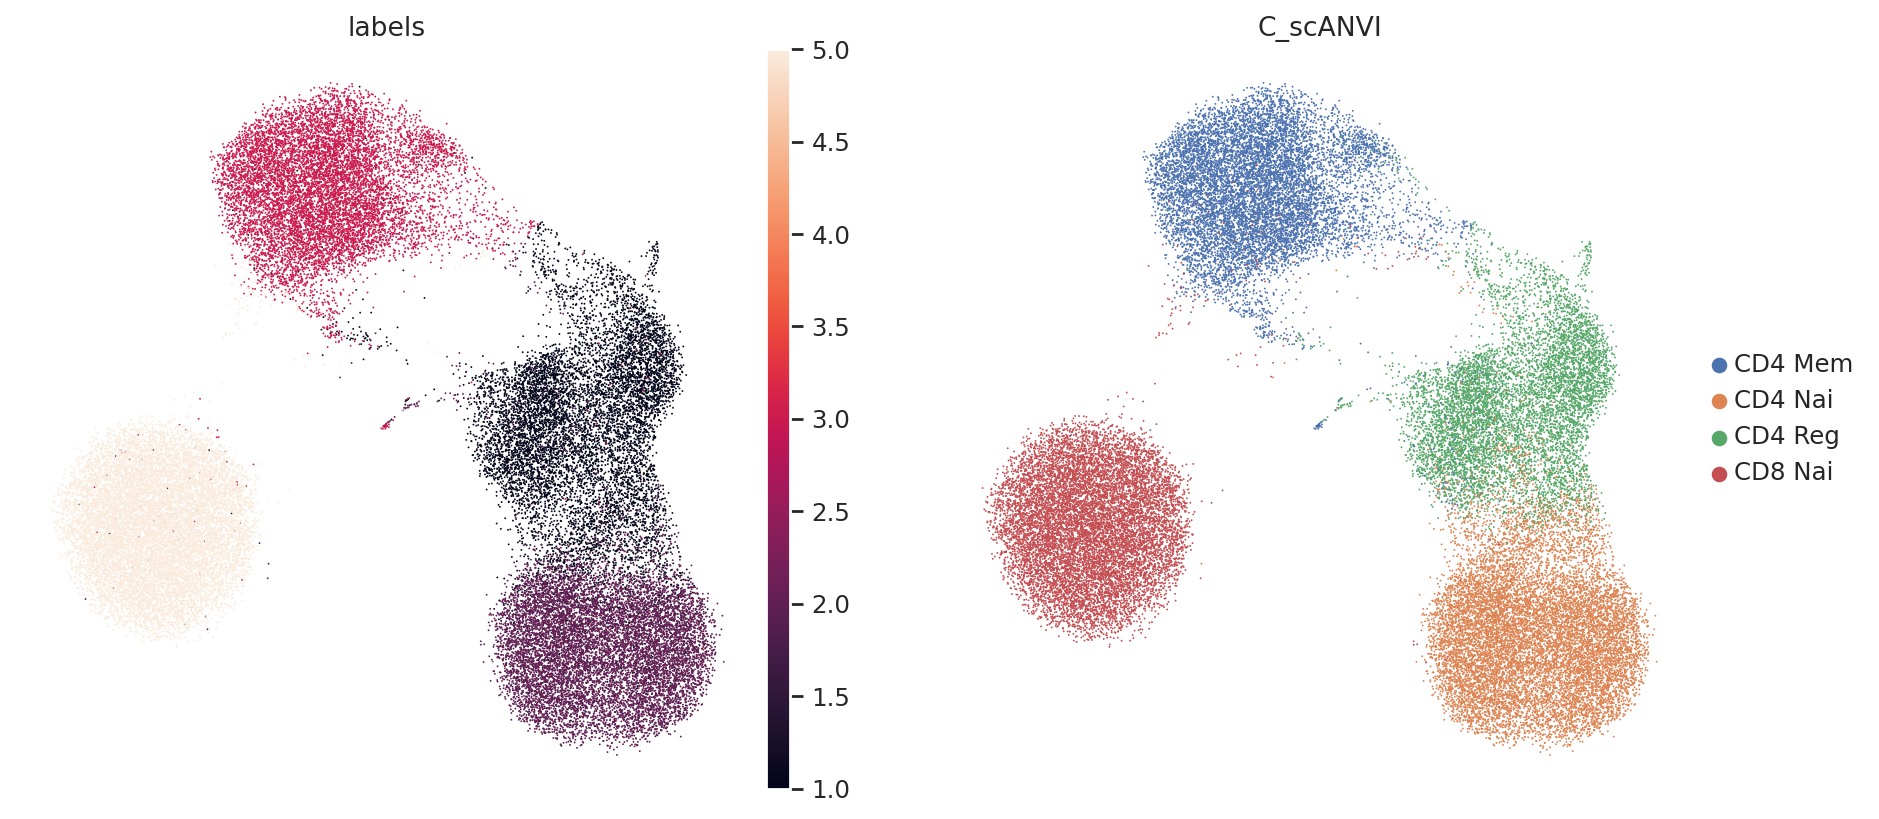

In [20]:
sc.pl.umap(adata, color=["labels", SCANVI_PREDICTIONS_KEY])

From this, we can see that it is relatively easy for scANVI to separate the CD4 T cells from the CD8 T cells (in latent space, as well as for the classifier). The regulatory CD4 T cells are sometimes missclassified into CD4 Naive, but this stays a minor phenomenon. Also, we expect that better results may be obtained by careful hyperparameter selection for the classifier. Learn about all of this in our [documentation](https://scvi.readthedocs.io/en/stable/).